In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
#upload the original nucleotide data 
d = pd.read_csv('2YJapanfeat.cvs', index_col=[0], header=None)
df = d.loc[:, (d != d.iloc[0]).any()]

# upload NBCI and worldometer features and fastahead
dfY = pd.read_csv('2YJapanCovid.csv', index_col=[0])
print(dfY.shape)
acc = pd.read_csv('2Yfastahead')

#add fastaheads to the feature dataframe
df = df.reset_index(drop=True)
stack = pd.concat([df, acc], axis=1)

(3392, 6)


In [3]:
#Merge the NBCI and worldometer data on t-SNE dimensions by sequence name, that is, by 'acc'
df_merged = pd.merge(dfY, stack, on='acc')

#add column deaths/cases
df_merged['death_rate'] = (df_merged['deaths']/df_merged['cases'])

#drop columns you dont need and choose features and target
df_merged.drop(columns=['acc', 'pango', 'locat', 'date', 'cases', 'deaths'], inplace=True)

x=df_merged.iloc[:,0:14027].values
y=df_merged.iloc[:,14027].values

In [4]:
#reshape, and transform
y=np.reshape(y, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_x.fit(x)
xscale=scaler_x.transform(x)
scaler_y.fit(y)
yscale=scaler_y.transform(y)

#split data to training and testing (75% training and 25% testing)
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)
print(X_train.shape)
print(X_test.shape)

(2541, 14027)
(848, 14027)


In [5]:
#model layears
model = Sequential()
model.add(Dense(7014, input_dim=14027, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3506, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1754, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(430, activation='relu'))
model.add(Dense(106, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7014)              98392392  
                                                                 
 dropout (Dropout)           (None, 7014)              0         
                                                                 
 dense_1 (Dense)             (None, 3506)              24594590  
                                                                 
 dropout_1 (Dropout)         (None, 3506)              0         
                                                                 
 dense_2 (Dense)             (None, 1754)              6151278   
                                                                 
 dropout_2 (Dropout)         (None, 1754)              0         
                                                                 
 dense_3 (Dense)             (None, 430)               7

In [6]:
#compile, fit and evaluate
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=100, batch_size=len(x),  verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, batch_size=len(x))
print(score)
print(history.history.keys())

Epoch 1/100
1/1 [==============================] - 23s 23s/step - loss: 7.6352 - mae: 2.2163 - val_loss: 1123425.5000 - val_mae: 1059.8345
Epoch 2/100
1/1 [==============================] - 12s 12s/step - loss: 1157431.2500 - mae: 1074.9646 - val_loss: 908.3261 - val_mae: 30.1364
Epoch 3/100
1/1 [==============================] - 13s 13s/step - loss: 1099.9900 - mae: 32.9720 - val_loss: 16.5650 - val_mae: 4.0676
Epoch 4/100
1/1 [==============================] - 12s 12s/step - loss: 18.1154 - mae: 4.1165 - val_loss: 1.2367 - val_mae: 1.1040
Epoch 5/100
1/1 [==============================] - 15s 15s/step - loss: 5.7772 - mae: 2.0878 - val_loss: 32.7852 - val_mae: 5.7239
Epoch 6/100
1/1 [==============================] - 14s 14s/step - loss: 24.5675 - mae: 4.7109 - val_loss: 63.9035 - val_mae: 7.9921
Epoch 7/100
1/1 [==============================] - 13s 13s/step - loss: 92.1620 - mae: 9.4449 - val_loss: 31.9533 - val_mae: 5.6507
Epoch 8/100
1/1 [==============================] - 14s 14s

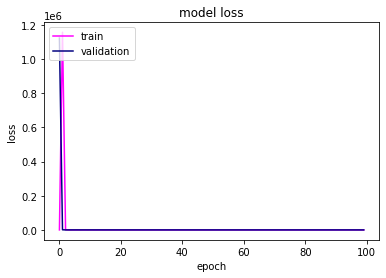

In [7]:
#Draw a "Loss" plot
plt.plot(history.history['loss'], color='magenta')
plt.plot(history.history['val_loss'], color='navy')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

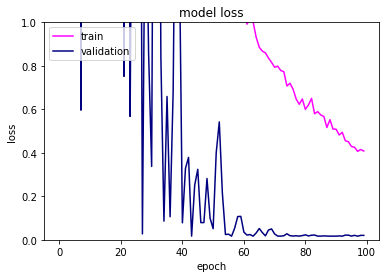

In [8]:
#plot magnification of the loss plot
plt.plot(history.history['loss'], color='magenta')
plt.plot(history.history['val_loss'], color='navy')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim((0,1))
plt.show()

In [10]:
#prediction with new virus sequence (AY3) 
d = pd.read_csv('AY3.csv', index_col=[0], header=None)

list = []
for col in df.columns:
    list.append(col)

new_df = d[list]
Xnew = scaler_x.transform(new_df)
ynew= model.predict(Xnew)

#invert normalize
ynew = scaler_y.inverse_transform(ynew) 
Xnew = scaler_x.inverse_transform(Xnew)
print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

X=[0. 0. 0. ... 0. 0. 0.], Predicted=[-0.00141574]
